# Imports

## Import Lib

In [496]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import re
import time
from sklearn.impute import KNNImputer

In [497]:
start_time = time.time()

## Import Csv

In [499]:
chunksize = 10 ** 3  # Chunksize de 1000 lignes
filename = 'products.csv'
nan_rates = []

try:
    reader = pd.read_csv(filename, chunksize=chunksize, sep='\t')

    for chunk in reader:
        nan_rates.append(chunk.isna().mean(axis=0))

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Calcul des taux moyens de remplissage des chunks
if nan_rates:
    inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
    cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()

    # Chargement des données filtrées
    df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)
    df = df.drop(['url','states','additives_n','main_category','completeness','nutrient_levels_tags','brands','nova_group','food_groups','categories','creator','pnns_groups_1','serving_size','serving_quantity','categories','image_nutrition_url','ingredients_analysis_tags','ingredients_tags','ingredients_text','image_nutrition_small_url','pnns_groups_2','created_datetime','food_groups_tags','food_groups_en','states_tags','sodium_100g','states_en','last_image_datetime','last_modified_t','last_modified_datetime','created_t','last_modified_by','main_category_en','image_url','image_small_url','last_updated_t','last_image_t','brands_tags','last_updated_datetime','categories_en','categories_tags','countries_tags','countries_en'], axis=1)
    print(df.head())
    
# Liste des mots clés à rechercher dans la colonne 'countries'
keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']

# Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de filtrage
df['countries'].fillna('', inplace=True)

# Filtrer les lignes où 'countries' ne contient pas les mots clés spécifiés
mask = df['countries'].str.contains('|'.join(keywords), case=False, na=False)
df = df[mask]

# Afficher le DataFrame principal après suppression des lignes indésirables
print("DataFrame principal après suppression des lignes ne contenant pas les mots clés dans 'countries':")
print(df)

ParserError: Error tokenizing data. C error: Expected 206 fields in line 1537879, saw 234



/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_7436/3534459519.py:20: DtypeWarning: Columns (0,50,52,56,58,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)


                     code      product_name  countries nutriscore_score  \
0       00000000000000225    jeunes pousses  en:france              NaN   
1  0000000000000207025004             Andrè      en:de              NaN   
2    00000000000003429145           L.casei      Spain              NaN   
3    00000000000026772226              Skyr     France             -5.0   
4           0000000000017  Vitória crackers     France              NaN   

  nutriscore_grade ecoscore_grade energy-kcal_100g energy_100g fat_100g  \
0          unknown              b              NaN         NaN      NaN   
1          unknown        unknown            165.0       690.0      2.0   
2          unknown        unknown              NaN         NaN      1.4   
3                a              b             57.0       238.0      0.2   
4          unknown        unknown            375.0      1569.0      7.0   

  saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0                NaN         

# Information de base

In [501]:
df.info

<bound method DataFrame.info of                          code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
3        00000000000026772226                          Skyr           France   
4               0000000000017              Vitória crackers           France   
5               0000000000031                         Cacao           France   
11              0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
3307643              99999995                Steak haché 5%           France   
3307647         9999999905667                           NaN  en:South Africa   
3307649         9999999916298       Beurre de cacahuète bio            en:fr   
3307652             999999999       Thé noir BIO Darjeeling        en:france   
3307657         9999999999994     Light & Free SKYR A BOIRE        en:france   

       

In [502]:
df.head(5)

,code,product_name,countries,nutriscore_score,nutriscore_grade,ecoscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,Skyr,France,-5.0,a,b,57.0,238.0,0.2,0.1,3.9,3.9,NaN,10.0,0.09,NaN,-5.0
4,0000000000017,Vitória crackers,France,NaN,unknown,unknown,375.0,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.40,NaN,NaN
5,0000000000031,Cacao,France,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0000000000100,moutarde au moût de raisin,France,18.0,d,c,NaN,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.60,0.0,18.0


In [503]:
df.dtypes

code                                                      object
product_name                                              object
countries                                                 object
nutriscore_score                                          object
nutriscore_grade                                          object
ecoscore_grade                                            object
energy-kcal_100g                                          object
energy_100g                                               object
fat_100g                                                  object
saturated-fat_100g                                        object
carbohydrates_100g                                       float64
sugars_100g                                              float64
fiber_100g                                               float64
proteins_100g                                            float64
salt_100g                                                float64
fruits-vegetables-nuts-es

# Nettoyage Données

## Suppression cyrillique

In [506]:
def detect_cyrillic(df, column):
    cyrillic_indices = []
    cyrillic_pattern = re.compile(r'[\u0400-\u04FF]+')  # Unicode Cyrillic characters

    for index, value in df[column].items():
        if isinstance(value, str) and cyrillic_pattern.search(value):
            cyrillic_indices.append(index)

    return cyrillic_indices

cyrillic_indices = detect_cyrillic(df, 'product_name')
df = df.drop(index=cyrillic_indices).reset_index(drop=True)
num_rows_removed = len(cyrillic_indices)
print(f"\nNombre de lignes supprimées : {num_rows_removed}")

print("\nDataFrame après suppression des lignes avec des caractères cyrilliques :")
print(df)


Nombre de lignes supprimées : 424

DataFrame après suppression des lignes avec des caractères cyrilliques :
                         code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
1        00000000000026772226                          Skyr           France   
2               0000000000017              Vitória crackers           France   
3               0000000000031                         Cacao           France   
4               0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
1070051              99999995                Steak haché 5%           France   
1070052         9999999905667                           NaN  en:South Africa   
1070053         9999999916298       Beurre de cacahuète bio            en:fr   
1070054             999999999       Thé noir BIO Darjeeling        en:france   
1070055    

## Focalisation marché Français

In [508]:
# Liste des mots clés à rechercher dans la colonne 'countries'
keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']

# Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de filtrage
df['countries'].fillna('', inplace=True)

# Filtrer les lignes où 'countries' ne contient pas les mots clés spécifiés
mask = df['countries'].str.contains('|'.join(keywords), case=False, na=False)
df = df[mask]

# Afficher le DataFrame principal après suppression des lignes indésirables
print("DataFrame principal après suppression des lignes ne contenant pas les mots clés dans 'countries':")
print(df)

DataFrame principal après suppression des lignes ne contenant pas les mots clés dans 'countries':
                         code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
1        00000000000026772226                          Skyr           France   
2               0000000000017              Vitória crackers           France   
3               0000000000031                         Cacao           France   
4               0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
1070051              99999995                Steak haché 5%           France   
1070052         9999999905667                           NaN  en:South Africa   
1070053         9999999916298       Beurre de cacahuète bio            en:fr   
1070054             999999999       Thé noir BIO Darjeeling        en:france   
1070055         999999

## Doublons

In [510]:
for column in df.columns:
    doublons = df[column].duplicated().sum()
    print(f"Column: {column}")
    print(doublons)

Column: code
2050
Column: product_name
396686
Column: countries
1062650
Column: nutriscore_score
1069956
Column: nutriscore_grade
1070048
Column: ecoscore_grade
1070048
Column: energy-kcal_100g
1058344
Column: energy_100g
1063275
Column: fat_100g
1061491
Column: saturated-fat_100g
1063654
Column: carbohydrates_100g
1059073
Column: sugars_100g
1061156
Column: fiber_100g
1066916
Column: proteins_100g
1063010
Column: salt_100g
1060733
Column: fruits-vegetables-nuts-estimate-from-ingredients_100g
1024049
Column: nutrition-score-fr_100g
1070000


### Suppression et verification des doublons dans 'code'

In [512]:
df = df.drop_duplicates(subset='code')
for column in df.columns:
    doublons = df[column].duplicated().sum()
    print(f"Column: {column}")
    print(doublons)

Column: code
0
Column: product_name
394687
Column: countries
1060602
Column: nutriscore_score
1067906
Column: nutriscore_grade
1067998
Column: ecoscore_grade
1067998
Column: energy-kcal_100g
1056294
Column: energy_100g
1061226
Column: fat_100g
1059441
Column: saturated-fat_100g
1061604
Column: carbohydrates_100g
1057023
Column: sugars_100g
1059106
Column: fiber_100g
1064866
Column: proteins_100g
1060960
Column: salt_100g
1058683
Column: fruits-vegetables-nuts-estimate-from-ingredients_100g
1022090
Column: nutrition-score-fr_100g
1067950


In [513]:
df.isna().any()

code                                                     False
product_name                                              True
countries                                                False
nutriscore_score                                          True
nutriscore_grade                                          True
ecoscore_grade                                            True
energy-kcal_100g                                          True
energy_100g                                               True
fat_100g                                                  True
saturated-fat_100g                                        True
carbohydrates_100g                                        True
sugars_100g                                               True
fiber_100g                                                True
proteins_100g                                             True
salt_100g                                                 True
fruits-vegetables-nuts-estimate-from-ingredients_100g  

In [514]:
df.isna().mean()

code                                                     0.000000
product_name                                             0.032748
countries                                                0.000000
nutriscore_score                                         0.614675
nutriscore_grade                                         0.009082
ecoscore_grade                                           0.001161
energy-kcal_100g                                         0.260513
energy_100g                                              0.239147
fat_100g                                                 0.245227
saturated-fat_100g                                       0.242347
carbohydrates_100g                                       0.245091
sugars_100g                                              0.242598
fiber_100g                                               0.745824
proteins_100g                                            0.243605
salt_100g                                                0.289969
fruits-veg

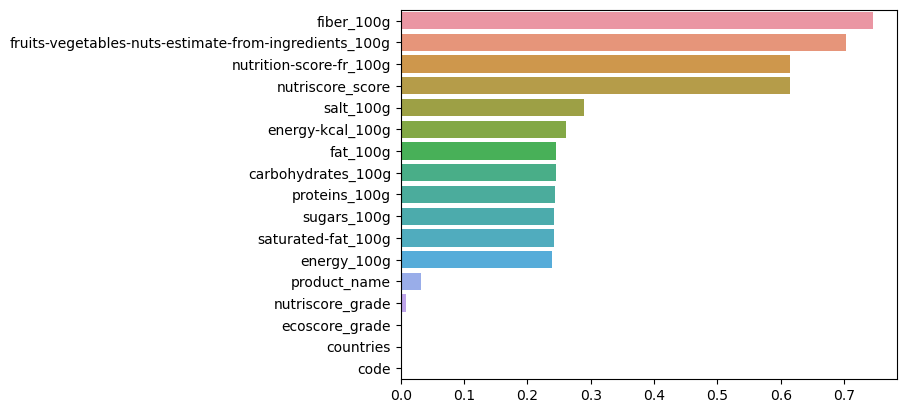

In [515]:
valeurs_manq = df.isna().mean().sort_values(ascending=False)
sns.barplot(x=valeurs_manq.values, y=valeurs_manq.index);

## Detection, modification et suppression des valeurs supérieures a 100 pour 100gr

In [517]:
def count_responses(results_df):
    return results_df.shape[0]

initial_size = df.shape[0]

columns_to_check = [
    'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

results = []

for column in columns_to_check:
    # Convertir les valeurs de la colonne en float (si possible)
    df.loc[:, column] = pd.to_numeric(df[column], errors='coerce')
    values_above_100 = df[df[column] > 100][column]
    for idx, value in values_above_100.items():
        results.append((df.loc[idx, 'product_name'], column, value))

results_df = pd.DataFrame(results, columns=['product_name', 'Column', 'Value'])

print("Produits avec des valeurs supérieures à 100 :")
print(results_df)

# Compter le total de réponses
total_responses = count_responses(results_df)
print(f"Total de réponses trouvées : {total_responses}")

Produits avec des valeurs supérieures à 100 :
                                           product_name  \
0       Peanut butter dark chocolate protein chewy bars   
1                                         Almond Butter   
2                                           Chouquettes   
3                              Equal dark chocolate bar   
4                                Blueberry bagel - Sola   
...                                                 ...   
1498                  sauce tomate cuisinée aux légumes   
1499                                         Energy fig   
1500  Vegetable hot & spicy with tomato carrot celer...   
1501                                      Peanut butter   
1502               Goji berries,fruits,nuts & chocolate   

                                                 Column      Value  
0                                              fat_100g  1200.0000  
1                                              fat_100g   272.0000  
2                                     

### Affichage valeur unique product_name

In [519]:
unique_product_counts = df['product_name'].value_counts()
print("Valeurs uniques dans la colonne 'product_name' et leur nombre :")
print(unique_product_counts)

Valeurs uniques dans la colonne 'product_name' et leur nombre :
product_name
Filet de poulet                        1171
Comté                                  1161
Miel                                   1059
Chocolat                                988
Poulet                                  852
                                       ... 
Morceaux d'agneau à brochette             1
Viande bovins angus                       1
Fromage blanc battu Vanille bourbon       1
Petites crèmes au four caramel            1
Light & Free SKYR A BOIRE                 1
Name: count, Length: 673318, dtype: int64


## Remplacement des >100 par la moyenne en fonction de product name

In [521]:
columns_to_check = [
    'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

# Convertir les valeurs des colonnes en float
df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')

# Calculer les moyennes des colonnes en fonction de 'product_name'
means = df.groupby('product_name')[columns_to_check].transform('mean')

# Remplacer les valeurs supérieures à 100 par la moyenne correspondante
for column in columns_to_check:
    df[column] = np.where(df[column] > 100, means[column], df[column])

# Vérifier les valeurs supérieures à 100 après correction
values_above_100 = df[columns_to_check] > 100
count_above_100 = values_above_100.sum().sum()
print(f"Nombre de valeurs supérieures à 100 après correction : {count_above_100}")

# Supprimer les lignes contenant des valeurs supérieures à 100
df.drop(index=df[values_above_100.any(axis=1)].index, inplace=True)
print("DataFrame après suppression des valeurs supérieures à 100 :")
print(df)

Nombre de valeurs supérieures à 100 après correction : 1290
DataFrame après suppression des valeurs supérieures à 100 :
                         code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
1        00000000000026772226                          Skyr           France   
2               0000000000017              Vitória crackers           France   
3               0000000000031                         Cacao           France   
4               0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
1070051              99999995                Steak haché 5%           France   
1070052         9999999905667                           NaN  en:South Africa   
1070053         9999999916298       Beurre de cacahuète bio            en:fr   
1070054             999999999       Thé noir BIO Darjeeling        en:france   


## Iterative imputer dans les valeurs NaN 

In [523]:
df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')

modified_count = 0

# Utiliser IterativeImputer pour remplacer les NaN
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df[columns_to_check])

# Compter les valeurs modifiées
for col in columns_to_check:
    modified_count += df[col].isna().sum() - np.isnan(df_imputed[:, columns_to_check.index(col)]).sum()

# Remplacer les valeurs NaN dans le DataFrame d'origine
df[columns_to_check] = df_imputed

# Afficher le DataFrame final après imputation
print("DataFrame après imputation itérative :")
print(df)

# Afficher le nombre de valeurs modifiées
print(f"Nombre de valeurs modifiées : {modified_count}")

DataFrame après imputation itérative :
                         code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
1        00000000000026772226                          Skyr           France   
2               0000000000017              Vitória crackers           France   
3               0000000000031                         Cacao           France   
4               0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
1070051              99999995                Steak haché 5%           France   
1070052         9999999905667                           NaN  en:South Africa   
1070053         9999999916298       Beurre de cacahuète bio            en:fr   
1070054             999999999       Thé noir BIO Darjeeling        en:france   
1070055         9999999999994     Light & Free SKYR A BOIRE        en:france   



/opt/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Suppression des NaN dans product_name

In [525]:
nombre_lignes_avant = df.shape[0]
df.dropna(subset=['product_name'], inplace=True)
nombre_lignes_apres = df.shape[0]
nombre_lignes_supprimees = nombre_lignes_avant - nombre_lignes_apres
print(f"\nNombre de lignes supprimées: {nombre_lignes_supprimees}")


Nombre de lignes supprimées: 34975


### Pourcentage des 0 et NaN restant

In [527]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

Pourcentage des valeurs égales à 0 :
code                                                      0.000000
product_name                                              0.000000
countries                                                 0.000000
nutriscore_score                                          1.970377
nutriscore_grade                                          0.000000
ecoscore_grade                                            0.000000
energy-kcal_100g                                          1.640172
energy_100g                                               1.649864
fat_100g                                                  8.155308
saturated-fat_100g                                       12.331481
carbohydrates_100g                                        5.402013
sugars_100g                                               9.533603
fiber_100g                                                6.275357
proteins_100g                                             6.807543
salt_100g                

In [528]:
df.head(5)

,code,product_name,countries,nutriscore_score,nutriscore_grade,ecoscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,b,NaN,NaN,14.253633,5.438414,27.020113,13.612964,2.908313,9.024707,1.251022,17.890937,NaN
1,00000000000026772226,Skyr,France,-5.0,a,b,57.0,238.0,0.200000,0.100000,3.900000,3.900000,1.697479,10.000000,0.090000,25.198626,-5.0
2,0000000000017,Vitória crackers,France,NaN,unknown,unknown,375.0,1569.0,7.000000,3.080000,70.100000,15.000000,4.973039,7.800000,1.400000,3.617474,NaN
3,0000000000031,Cacao,France,NaN,unknown,unknown,NaN,NaN,14.253633,5.438414,27.020113,13.612964,2.908313,9.024707,1.251022,17.890937,NaN
4,0000000000100,moutarde au moût de raisin,France,18.0,d,c,NaN,936.0,8.200000,2.200000,29.000000,22.000000,0.000000,5.100000,4.600000,0.000000,18.0


## Modifications valeurs negatives

In [530]:
columns_to_check = [
    'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'
]

# Supprimer les lignes avec des valeurs négatives dans les colonnes spécifiées
for column in columns_to_check:
    df = df[df[column] >= 0]

# Afficher le résumé des valeurs négatives supprimées
print("\nRésumé des lignes supprimées contenant des valeurs négatives :")
for column, count in negative_values.items():
    print(f"Colonne '{column}': {count} lignes supprimées contenant des valeurs négatives")


Résumé des lignes supprimées contenant des valeurs négatives :
Colonne 'fat_100g': 81 lignes supprimées contenant des valeurs négatives
Colonne 'saturated-fat_100g': 4079 lignes supprimées contenant des valeurs négatives
Colonne 'carbohydrates_100g': 157 lignes supprimées contenant des valeurs négatives
Colonne 'sugars_100g': 1078 lignes supprimées contenant des valeurs négatives
Colonne 'fiber_100g': 24763 lignes supprimées contenant des valeurs négatives
Colonne 'proteins_100g': 3160 lignes supprimées contenant des valeurs négatives
Colonne 'salt_100g': 2396 lignes supprimées contenant des valeurs négatives


In [531]:
# Convertir la colonne 'energy-kcal_100g' en numérique
df['energy-kcal_100g'] = pd.to_numeric(df['energy-kcal_100g'], errors='coerce')

# Vérifier, compter et afficher les lignes où la valeur est supérieure à 900
column_to_check = 'energy-kcal_100g'
high_energy_rows = df[df[column_to_check] > 900]
count_high_energy = high_energy_rows.shape[0]

print(f"Nombre de lignes où '{column_to_check}' est supérieur à 900 : {count_high_energy}")
print("Lignes correspondantes :")
print(high_energy_rows)

Nombre de lignes où 'energy-kcal_100g' est supérieur à 900 : 945
Lignes correspondantes :
                       code                                      product_name  \
57            0000000004206            Saucisse au chou fumé BBC SV (Morteau)   
1034              000113058  Complete breakfast smoothie stranwberry & banana   
1035              000113405                                   Ultra fine oats   
1038              000113584                                       Cramberries   
1078              000121805                          Complete shake tout en 1   
...                     ...                                               ...   
1065704       9421023620685                              Manuka Honning Mgo +   
1068463       9782356854100                                        Fantastich   
1068625       9782871294276                                          Mammouth   
1069420  990530101033281503                               Spécial mie complet   
1069547  9905301010

In [532]:
df.head(10)

,code,product_name,countries,nutriscore_score,nutriscore_grade,ecoscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,b,NaN,NaN,14.253633,5.438414,27.020113,13.612964,2.908313,9.024707,1.251022,17.890937,NaN
1,00000000000026772226,Skyr,France,-5.0,a,b,57.0,238.0,0.200000,0.100000,3.900000,3.900000,1.697479,10.000000,0.090000,25.198626,-5.0
2,0000000000017,Vitória crackers,France,NaN,unknown,unknown,375.0,1569.0,7.000000,3.080000,70.100000,15.000000,4.973039,7.800000,1.400000,3.617474,NaN
3,0000000000031,Cacao,France,NaN,unknown,unknown,NaN,NaN,14.253633,5.438414,27.020113,13.612964,2.908313,9.024707,1.251022,17.890937,NaN
4,0000000000100,moutarde au moût de raisin,France,18.0,d,c,NaN,936.0,8.200000,2.200000,29.000000,22.000000,0.000000,5.100000,4.600000,0.000000,18.0
5,0000000000123,Sauce Sweety chili 0%,France,NaN,unknown,unknown,21.0,88.0,0.000000,0.000000,4.800000,0.400000,0.924553,0.200000,2.040000,31.076160,NaN
6,0000000000178,Mini coco,France,NaN,unknown,unknown,60.0,251.0,3.000000,1.000000,10.000000,3.000000,1.372580,2.000000,1.150000,28.621751,NaN
7,0000000000208,Pistou d'ail des ours,France,NaN,unknown,unknown,NaN,NaN,14.253633,5.438414,27.020113,13.612964,2.908313,9.024707,1.251022,17.890937,NaN
8,000000000025,Thé noir glacé pomme,en:fr,NaN,unknown,unknown,52.0,218.0,0.500000,0.100000,12.000000,11.000000,1.025787,0.500000,1.191993,31.305498,NaN
9,0000000000284,Pain maïs,en:france,NaN,unknown,unknown,NaN,NaN,14.253633,5.438414,27.020113,13.612964,2.908313,9.024707,1.251022,17.890937,NaN


# Timer

In [534]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Temps d'exécution total du notebook : {execution_time:.4f} secondes")

Temps d'exécution total du notebook : 196.6930 secondes


In [535]:
# TBD Regrouper tout preprocess en une fonction unique